# Census
Natalia Vélez, December 2019

In [1]:
%matplotlib inline

import os, re, glob, datetime
import numpy as np
import pandas as pd
from os.path import join as opj
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
from calplot import calplot, yearplot

import sys
sys.path.append('..')
from utils import gsearch, str_extract, int_extract

## Load data

Find data files:

In [2]:
data_dir = '../../data'
data_files = gsearch(data_dir, 'publicLifeLogData', 'lifeLog*', '*y.txt')
print('%i files found' % len(data_files))
print(*data_files[:10], sep='\n')

799 files found
../../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_16_Sunday.txt
../../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_17_Wednesday.txt
../../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_17_Saturday.txt
../../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_03March_01_Friday.txt
../../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_26_Thursday.txt
../../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_04_Saturday.txt
../../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_12December_10_Thursday.txt
../../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_02_Monday.txt
../../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_09September_19_Saturday.txt
../../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_28_Tuesday.txt


Load each file, tabulate # of births and deaths:

In [3]:
data_list = []

for f in tqdm_notebook(data_files):
    
    server = str_extract('(?<=lifeLog_)[A-Za-z0-9]+', f)

    year = str_extract('[0-9]{4}', f)
    month = str_extract('(?<=[0-9]{4}_)[0-9]{2}', f)
    day = str_extract('[0-9]{2}(?=_[A-Za-z]+.txt)', f)
    date = '%s-%s-%s' % (year, month, day)

    # Read data
    try:
        tmp_d = pd.read_csv(f, sep=' ', header=None,
                            encoding = 'ISO-8859-1', engine='python', error_bad_lines=False)
        tmp_d.head()

        # Tally events
        n_deaths = np.sum(tmp_d.iloc[:,0] == 'D')
        n_births = np.sum(tmp_d.iloc[:,0] == 'B')
    except pd.errors.EmptyDataError:
        
        n_deaths = 0
        n_births = 0

    data_list.append([server, year, month, day, date, n_deaths, n_births])

<ipython-input-3-17521fac6d58>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm_notebook(data_files):


  0%|          | 0/799 [00:00<?, ?it/s]

Clean up data frame:

In [4]:
data = pd.DataFrame(data_list, 
                    columns=['server', 'year', 'month', 'day', 'date',
                             'n_deaths', 'n_births'])

# Change dates to correct datatype
date_cols = ['year', 'month', 'day']
data[date_cols] = data[date_cols].apply(pd.to_numeric, errors='coerce')
data['date'] = pd.to_datetime(data['date'])

# Sort
data.sort_values(by=['date', 'server'], inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()

,server,year,month,day,date,n_deaths,n_births
0,bigserver2,2019,1,29,2019-01-29,0,1
1,bigserver2,2019,1,30,2019-01-30,11958,12116
2,bigserver2,2019,1,31,2019-01-31,12690,12685
3,bigserver2,2019,2,1,2019-02-01,11263,11292
4,bigserver2,2019,2,2,2019-02-02,15040,15074


## Overall activity in each server

Total events:

In [5]:
total_deaths = np.sum(data['n_deaths'])
total_births = np.sum(data['n_births'])

print('Deaths: %i' % total_deaths)
print('Births: %i' % total_births)

Deaths: 3824777
Births: 3834737


Aggregate birth/deaths by server, collapsing across all dates:

In [6]:
# Aggregate & reshape
server_summ = data.groupby(['server'])['n_deaths', 'n_births'].agg('sum').reset_index()
server_summ = server_summ.melt(id_vars=['server'],
                               value_vars=['n_deaths', 'n_births'],
                               var_name='event', value_name='n')

# Clean up dataframe
server_summ['event'] = server_summ['event'].apply(lambda s: s.replace('n_', ''))
server_summ.sort_values(by=['server', 'event'], inplace=True)

server_summ.head()

<ipython-input-6-5c04186a15be>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  server_summ = data.groupby(['server'])['n_deaths', 'n_births'].agg('sum').reset_index()


,server,event,n
1,bigserver2,births,3834737
0,bigserver2,deaths,3824777


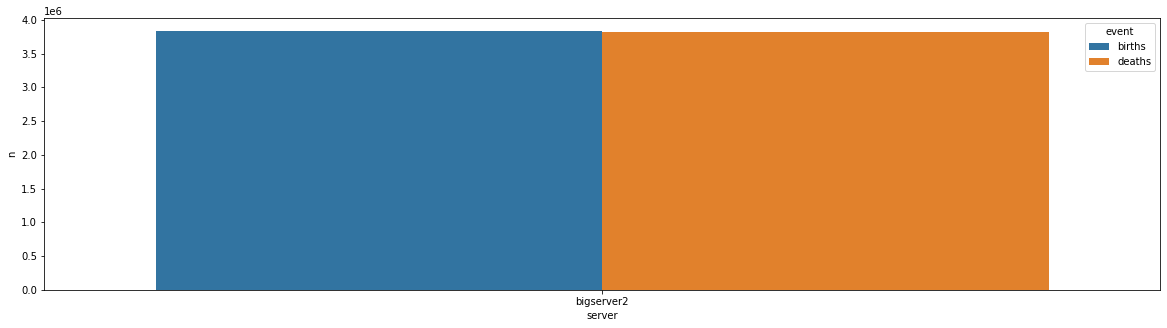

In [7]:
plt.figure(figsize=(20,5))
g = sns.barplot(data=server_summ, x='server', y='n', hue='event')

Log scale:

[None, (1, 4000000.0)]

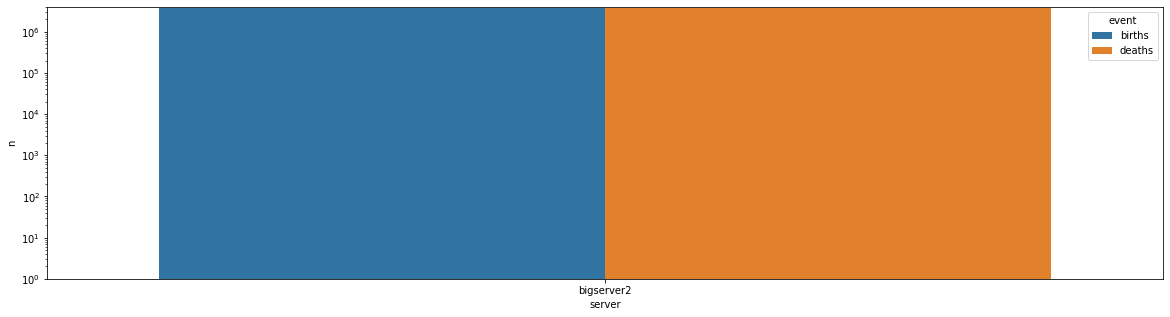

In [8]:
plt.figure(figsize=(20,5))
g = sns.barplot(data=server_summ, x='server', y='n', hue='event')

# Set scale
max_scale = np.amax(server_summ['n'])
ymin = 1
ymax = np.ceil(max_scale/500000)*500000
g.set(yscale='log', ylim=[ymin, ymax])

## Activity by date

### Overall

Aggregate activity by date, collapsing across servers:

In [9]:
data_across_servers = data.groupby(['year', 'month','day',  'date'])['n_deaths', 'n_births']
date_summ = data_across_servers.agg('sum').reset_index()

date_summ.head()

<ipython-input-9-aa9e242aebe2>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_across_servers = data.groupby(['year', 'month','day',  'date'])['n_deaths', 'n_births']


,year,month,day,date,n_deaths,n_births
0,2019,1,29,2019-01-29,0,1
1,2019,1,30,2019-01-30,11958,12116
2,2019,1,31,2019-01-31,12690,12685
3,2019,2,1,2019-02-01,11263,11292
4,2019,2,2,2019-02-02,15040,15074


Calendar plot:

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


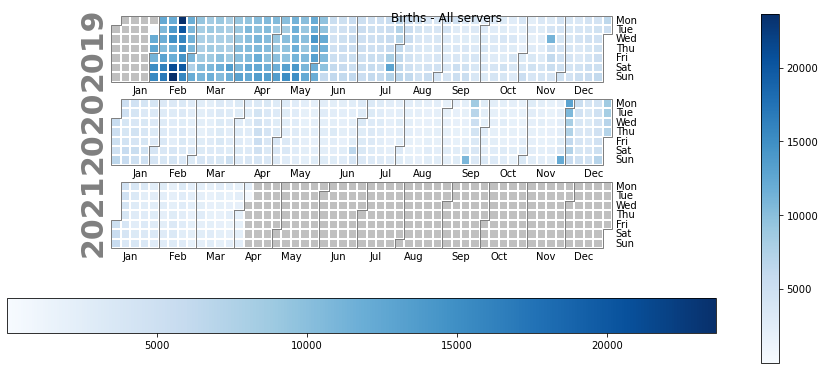

In [10]:
birth_events = pd.Series(date_summ['n_births'].values, index=date_summ['date'])

fig,ax = calplot(birth_events, cmap='Blues', fillcolor='silver')

fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist(), orientation = 'horizontal')
fig.suptitle('Births - All servers')
fig.savefig('plots/census_births_all.png')

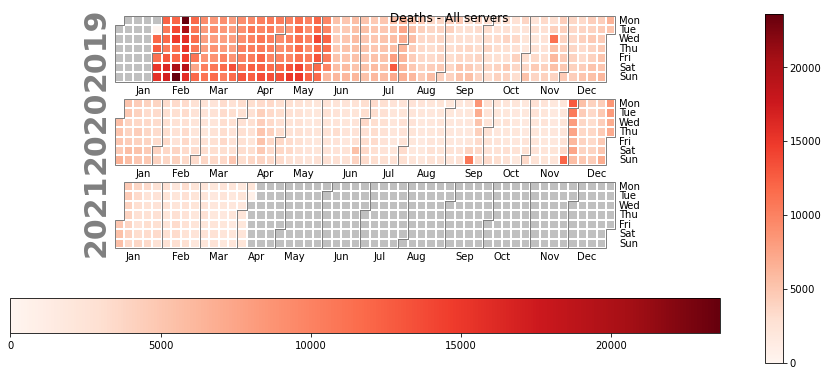

In [11]:
death_events = pd.Series(date_summ['n_deaths'].values, index=date_summ['date'])

fig,ax = calplot(death_events, cmap='Reds', fillcolor='silver')
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist(), orientation = 'horizontal')
fig.suptitle('Deaths - All servers')
fig.savefig('plots/census_deaths_all.png')

### By server

In [12]:
servers = data['server'].unique()
servers.sort()
print(servers)
print('Plotting activity for %i servers' % len(servers))

['bigserver2']
Plotting activity for 1 servers


Helper function: Generate calendar plot of births for each server

In [13]:
def server_calendar(s):
    s_data = data[data['server'] == s]

    # Plot births
    s_births = pd.Series(s_data['n_births'].values, index=s_data['date'])

    fig,ax = calplot(s_births, cmap='Blues', fillcolor='silver')
    fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist(), orientation = 'horizontal')
    fig.suptitle('Births - %s' % s)
    fig.savefig('plots/census_births_%s.png' % s)

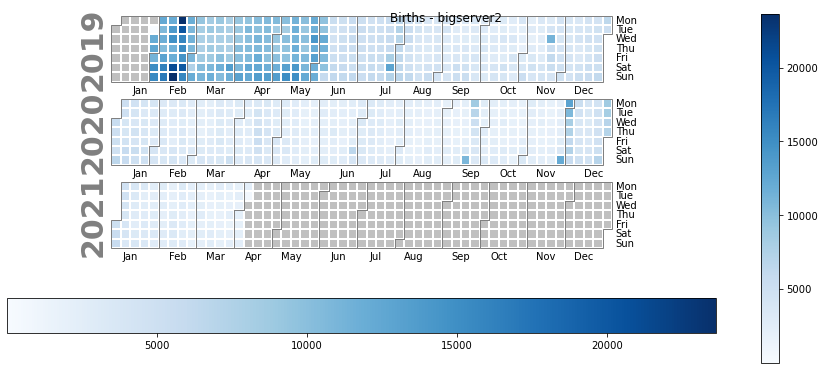

In [14]:
for s in servers:
    server_calendar(s)

## Zoom in on activity during Boundless World era

Find start of new map logs:

In [15]:
map_files = gsearch(data_dir, 'publicMapChangeData', 'bigserver2.onehouronelife.com', '*time_mapLog.txt')
map_files.sort()

print('%i files found' % len(map_files))

269 files found


### Timing of map seed changes

Find all map seed times:

In [16]:
seed_files = gsearch(data_dir, 'publicMapChangeData', 'bigserver2.onehouronelife.com', '*time_mapSeed.txt')
seed_files.sort()

seed_times = [int_extract(r'([0-9]+)(?=time)', f) for f in seed_files]

print('%i seed changes' % len(seed_files))
print(*[datetime.datetime.fromtimestamp(t) for t in seed_times], sep='\n')

17 seed changes
2019-11-16 04:14:33
2019-11-18 13:41:43
2019-12-10 23:31:11
2020-01-06 16:22:00
2020-01-06 18:52:27
2020-01-22 12:18:39
2020-01-27 12:08:16
2020-02-17 19:18:59
2020-03-07 23:48:23
2020-03-12 21:04:44
2020-03-28 20:08:31
2020-03-29 16:12:50
2020-03-30 17:24:41
2020-04-17 19:37:36
2020-10-29 14:54:07
2020-12-19 16:01:14
2020-12-28 10:47:31


Number of active users per epoch:

Find last seed: